# Creating Topography Variables

In [10]:
%load_ext jupyter_black
from pathlib import Path
import os
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.merge import merge
from rasterstats import zonal_stats
import numpy as np

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


In [11]:
base_url = Path(os.getenv("STORM_DATA_DIR")) / "analysis/02_new_model_input/"
input_dir = base_url / "04_topography/input/srtm/"
output_dir = base_url / "04_topography/output/"
shp_output_dir = base_url / "02_housing_damage/output/"

In [12]:
grid = gpd.read_file(shp_output_dir / "phl_0.1_degree_grid_land_overlap.gpkg")

In [13]:
adm3_shp = gpd.read_file(
    base_url / "02_housing_damage/input/phl_adminboundaries_candidate_adm3.zip"
)

In [ ]:
# reading in the files
# merging rasters
fileList = os.listdir(input_dir)
mosaic_raster = []
for file in fileList:
    rast = rasterio.open(input_dir / file)
    mosaic_raster.append(rast)

merged_raster, out_raster = merge(mosaic_raster)

In [ ]:
out_meta = rast.meta.copy()
out_meta.update(
    {
        "driver": "GTiff",
        "height": merged_raster.shape[1],
        "width": merged_raster.shape[2],
        "transform": out_raster,
        "crs": grid.crs,
    }
)

In [ ]:
with rasterio.open(input_dir / "phl_merged_srtm.tif", "w", **out_meta) as dest:
    dest.write(merged_raster)

In [14]:
merged_rast = rasterio.open(input_dir / "phl_merged_srtm.tif")
merged_array = merged_rast.read(1)

In [8]:
# One way of computing topography variables
# GUI will pop up to have options for data input.
# Compute the slope and ruggedness using it.
# Expand Geomorphomentric Analysis
# Select slope, enter input DEM file which is the merged file and the output file,
# leave everything as is making sure units is degrees and click on Run.
# Once complete, select RuggednessIndex, enter input DEM file (merged file)
# and output file name and click Run.
# Once complete, close the box.

# whitebox.Runner()

In [60]:
phl_merged_srtm = input_dir / "phl_merged_srtm.tif"

# Testing out new way of computing slope and TRI.
!gdalinfo \
"{phl_merged_srtm}"

Driver: GTiff/GeoTIFF
Files: G:\Shared drives\Predictive Analytics\Collaborations\ISI\data\analysis\02_new_model_input\04_topography\input\srtm\phl_merged_srtm.tif
Size is 24000, 24000
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (110.000000000000000,25.000000000000000)
Pixel Size = (0.000833333333333,-0.000833333333333)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  ( 110.0000000,  25.0000000) (110d 0' 0.00"E

In [61]:
## slope
phl_slope_gdaldem = input_dir / "phl_slope_gdaldem.tif"
!gdaldem slope -s 111120 -co COMPRESS=DEFLATE -co ZLEVEL=9 \
"{phl_merged_srtm}" "{phl_slope_gdaldem}" -compute_edges

0...10...20...30...40...50...60...70...80...90...100 - done.


ERROR 1: Deleting G:\Shared drives\Predictive Analytics\Collaborations\ISI\data\analysis\02_new_model_input\04_topography\input\srtm\phl_slope_gdaldem.tif failed:
Permission denied


In [8]:
## calculate  Terrain Ruggedness Index TRI
phl_tri_gdaldem = input_dir / "phl_tri_gdaldem.tif"
!gdaldem TRI -co COMPRESS=DEFLATE -co ZLEVEL=9 \
"{phl_merged_srtm}" "{phl_tri_gdaldem}" -compute_edges

0...10...20...30...40...50...60...70...80...90...100 - done.


## Slope

In [22]:
# code to compute the slope using rich dem if needed

# sp_dem = rd.rdarray(merged_array, no_data=rast.nodata)
# slope = rd.TerrainAttribute(sp_dem, attrib="slope_riserun")
# rd.rdShow(slope, axes=False, cmap="magma", figsize=(20, 12))
# plt.show()
# profile = merged_rast.profile
# profile["nodata"] = -9999.0
# profile["dtype"] = slope.dtype
# with rasterio.open(input_dir / "phl_slope.tif", "w", **profile) as dst:
#     dst.write(slope, 1)
# slope_rast = rasterio.open(input_dir / "phl_slope.tif")
# slope_array = slope_rast.read(1)

### Mean Slope and Deviation

In [134]:
slope_rast = rasterio.open(input_dir / "phl_slope_gdaldem.tif")
slope_array = slope_rast.read(1)
summary_stats = zonal_stats(
    grid,
    slope_array,
    stats=["mean", "std"],
    nodata=-9999,
    all_touched=True,
    affine=merged_rast.transform,
)
grid_slope = pd.DataFrame(summary_stats)
grid_slope_df = pd.concat([grid, grid_slope], axis=1)
grid_slope_df

,id,Longitude,Latitude,Centroid,geometry,mean,std
0,101,114.3,11.1,114.3E_11.1N,"POLYGON ((114.25000 11.15000, 114.35000 11.150...",1.018526,0.481382
1,4475,116.9,7.9,116.9E_7.9N,"POLYGON ((116.85000 7.95000, 116.95000 7.95000...",1.579400,1.060468
2,4639,117.0,8.2,117.0E_8.2N,"POLYGON ((116.95000 8.25000, 117.05000 8.25000...",0.551764,0.298116
3,4640,117.0,8.1,117.0E_8.1N,"POLYGON ((116.95000 8.15000, 117.05000 8.15000...",2.107949,2.638290
4,4641,117.0,8.0,117.0E_8.0N,"POLYGON ((116.95000 8.05000, 117.05000 8.05000...",3.538881,3.981129
...,...,...,...,...,...,...,...
3721,20677,126.6,7.6,126.6E_7.6N,"POLYGON ((126.55000 7.65000, 126.65000 7.65000...",3.790141,4.198243
3722,20678,126.6,7.5,126.6E_7.5N,"POLYGON ((126.55000 7.55000, 126.65000 7.55000...",3.532580,3.041204
3723,20679,126.6,7.4,126.6E_7.4N,"POLYGON ((126.55000 7.45000, 126.65000 7.45000...",4.444498,2.646619
3724,20680,126.6,7.3,126.6E_7.3N,"POLYGON ((126.55000 7.35000, 126.65000 7.35000...",5.816195,4.268518


## Mean Elevation

In [135]:
# computing stats
# checking if crs are the same
summary_stats = zonal_stats(
    grid,
    merged_array,
    stats=["mean"],
    nodata=-32768,
    all_touched=True,
    affine=merged_rast.transform,
)
grid_elev = pd.DataFrame(summary_stats)
grid_elev_df = pd.concat([grid, grid_elev], axis=1)
grid_elev_df

,id,Longitude,Latitude,Centroid,geometry,mean
0,101,114.3,11.1,114.3E_11.1N,"POLYGON ((114.25000 11.15000, 114.35000 11.150...",5.762712
1,4475,116.9,7.9,116.9E_7.9N,"POLYGON ((116.85000 7.95000, 116.95000 7.95000...",12.799127
2,4639,117.0,8.2,117.0E_8.2N,"POLYGON ((116.95000 8.25000, 117.05000 8.25000...",8.833333
3,4640,117.0,8.1,117.0E_8.1N,"POLYGON ((116.95000 8.15000, 117.05000 8.15000...",17.530431
4,4641,117.0,8.0,117.0E_8.0N,"POLYGON ((116.95000 8.05000, 117.05000 8.05000...",31.931338
...,...,...,...,...,...,...
3721,20677,126.6,7.6,126.6E_7.6N,"POLYGON ((126.55000 7.65000, 126.65000 7.65000...",36.304688
3722,20678,126.6,7.5,126.6E_7.5N,"POLYGON ((126.55000 7.55000, 126.65000 7.55000...",65.687266
3723,20679,126.6,7.4,126.6E_7.4N,"POLYGON ((126.55000 7.45000, 126.65000 7.45000...",37.414996
3724,20680,126.6,7.3,126.6E_7.3N,"POLYGON ((126.55000 7.35000, 126.65000 7.35000...",105.812452


## Ruggedness

### Mean ruggedness and deviation

In [136]:
tri_rast = rasterio.open(input_dir / "phl_tri_gdaldem.tif")
tri_array = tri_rast.read(1)
summary_stats = zonal_stats(
    grid,
    tri_array,
    stats=["mean", "std"],
    nodata=-9999,
    all_touched=True,
    affine=merged_rast.transform,
)
grid_tri = pd.DataFrame(summary_stats)
grid_tri_df = pd.concat([grid, grid_tri], axis=1)
grid_tri_df

,id,Longitude,Latitude,Centroid,geometry,mean,std
0,101,114.3,11.1,114.3E_11.1N,"POLYGON ((114.25000 11.15000, 114.35000 11.150...",6.438706,2.699781
1,4475,116.9,7.9,116.9E_7.9N,"POLYGON ((116.85000 7.95000, 116.95000 7.95000...",9.694848,4.585088
2,4639,117.0,8.2,117.0E_8.2N,"POLYGON ((116.95000 8.25000, 117.05000 8.25000...",3.985103,1.527495
3,4640,117.0,8.1,117.0E_8.1N,"POLYGON ((116.95000 8.15000, 117.05000 8.15000...",11.792592,11.677657
4,4641,117.0,8.0,117.0E_8.0N,"POLYGON ((116.95000 8.05000, 117.05000 8.05000...",18.718779,17.074011
...,...,...,...,...,...,...,...
3721,20677,126.6,7.6,126.6E_7.6N,"POLYGON ((126.55000 7.65000, 126.65000 7.65000...",20.390768,18.012771
3722,20678,126.6,7.5,126.6E_7.5N,"POLYGON ((126.55000 7.55000, 126.65000 7.55000...",18.949623,13.163042
3723,20679,126.6,7.4,126.6E_7.4N,"POLYGON ((126.55000 7.45000, 126.65000 7.45000...",22.290623,10.901755
3724,20680,126.6,7.3,126.6E_7.3N,"POLYGON ((126.55000 7.35000, 126.65000 7.35000...",28.143405,17.917650


## Coast

<AxesSubplot: >

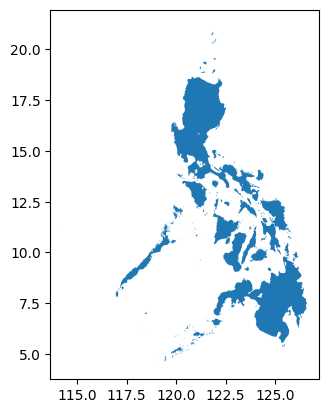

In [7]:
# dissolving polygons into one land mass
dissolved_shp = adm3_shp.dissolve(by="ADM0_PCODE")
dissolved_shp.loc[:, "geometry"].plot()

<AxesSubplot: >

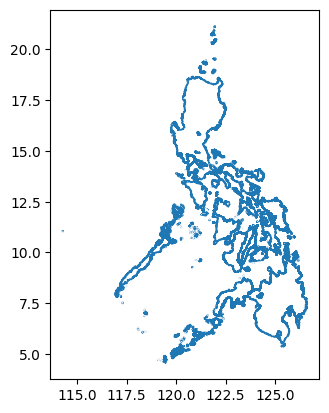

In [8]:
coastline = dissolved_shp.boundary
coastline.plot()

### With Coast and Coast Length

In [125]:
grid_line_gdf = gpd.overlay(
    gpd.GeoDataFrame(
        coastline, geometry=coastline.geometry, crs=grid.crs
    ).reset_index(),
    grid,
    how="intersection",
)[["id", "Centroid", "geometry"]]

In [128]:
## Pending: Confirm which CRS to use.
grid_line_gdf["coast_length"] = grid_line_gdf["geometry"].to_crs(25394).length

In [139]:
grid_coast = grid[["id", "Centroid"]].merge(
    grid_line_gdf, on=["id", "Centroid"], how="left"
)
grid_coast

,id,Centroid,geometry,coast_length
0,101,114.3E_11.1N,"LINESTRING (114.28703 11.05093, 114.28654 11.0...",3445.709753
1,4475,116.9E_7.9N,"LINESTRING (116.95000 7.91841, 116.94961 7.918...",8602.645832
2,4639,117.0E_8.2N,"LINESTRING (117.01024 8.18009, 117.01025 8.180...",5084.012925
3,4640,117.0E_8.1N,"MULTILINESTRING ((116.96474 8.05000, 116.96489...",55607.865950
4,4641,117.0E_8.0N,"MULTILINESTRING ((116.96622 7.95000, 116.96622...",35529.342507
...,...,...,...,...
3721,20677,126.6E_7.6N,"LINESTRING (126.55696 7.65000, 126.55696 7.650...",21559.003490
3722,20678,126.6E_7.5N,"LINESTRING (126.58427 7.55000, 126.58430 7.549...",12591.742022
3723,20679,126.6E_7.4N,"MULTILINESTRING ((126.59516 7.45000, 126.59515...",19740.596834
3724,20680,126.6E_7.3N,"LINESTRING (126.55449 7.35000, 126.55449 7.350...",26363.303778


In [140]:
grid_coast["with_coast"] = np.where(grid_coast["coast_length"] > 0, 1, 0)
grid_coast["with_coast"].value_counts()

1    2114
0    1612
Name: with_coast, dtype: int64

In [141]:
grid_coast.drop("geometry", axis=1, inplace=True)
grid_coast

,id,Centroid,coast_length,with_coast
0,101,114.3E_11.1N,3445.709753,1
1,4475,116.9E_7.9N,8602.645832,1
2,4639,117.0E_8.2N,5084.012925,1
3,4640,117.0E_8.1N,55607.865950,1
4,4641,117.0E_8.0N,35529.342507,1
...,...,...,...,...
3721,20677,126.6E_7.6N,21559.003490,1
3722,20678,126.6E_7.5N,12591.742022,1
3723,20679,126.6E_7.4N,19740.596834,1
3724,20680,126.6E_7.3N,26363.303778,1


## Writing CSV file

In [137]:
# write output
grid_out = (
    grid_slope_df[["id", "Centroid", "mean", "std"]]
    .merge(
        grid_tri_df[["id", "Centroid", "mean", "std"]],
        on=["id", "Centroid"],
        suffixes=("_slope", "_tri"),
    )
    .merge(
        grid_elev_df[["id", "Centroid", "mean"]],
        on=["id", "Centroid"],
        suffixes=(None, "_elev"),
    )
    .merge(
        grid_coast,
        on=["id", "Centroid"],
    )
)
grid_out.rename(columns={"mean": "mean_elev"}, inplace=True)
grid_out

,id,Centroid,mean_slope,std_slope,mean_tri,std_tri,mean_elev,coast_length,with_coast
0,101,114.3E_11.1N,1.018526,0.481382,6.438706,2.699781,5.762712,3445.709753,1
1,4475,116.9E_7.9N,1.579400,1.060468,9.694848,4.585088,12.799127,8602.645832,1
2,4639,117.0E_8.2N,0.551764,0.298116,3.985103,1.527495,8.833333,5084.012925,1
3,4640,117.0E_8.1N,2.107949,2.638290,11.792592,11.677657,17.530431,55607.865950,1
4,4641,117.0E_8.0N,3.538881,3.981129,18.718779,17.074011,31.931338,35529.342507,1
...,...,...,...,...,...,...,...,...,...
3721,20677,126.6E_7.6N,3.790141,4.198243,20.390768,18.012771,36.304688,21559.003490,1
3722,20678,126.6E_7.5N,3.532580,3.041204,18.949623,13.163042,65.687266,12591.742022,1
3723,20679,126.6E_7.4N,4.444498,2.646619,22.290623,10.901755,37.414996,19740.596834,1
3724,20680,126.6E_7.3N,5.816195,4.268518,28.143405,17.917650,105.812452,26363.303778,1


In [138]:
grid_out.to_csv(output_dir / "topography_variables_bygrid.csv", index=False)